# Forward modelling with Marmousi velocity model

In this example we will load the Marmousi 1 Vp model, specify source and receiver locations, and then use Deepwave to perform forward modelling, propagating the sources through the model to generate synthetic receiver data.

First, we need to import the necessary packages:

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import deepwave
from deepwave import scalar
import sys

import numpy as np

sys.path.append('../')
import functions as f

We then choose which device we wish to run on, specify the size of the model, and load it:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')

In [3]:
# ny = 2301
# nx = 751
ny = 2301
nx = 751
dx = 0.5

v = 1500 * torch.ones(ny, nx)
v[int(ny/2):] = 2000

# marmousi_offset_left = 200
# marmousi_offset_right = 0
# ny = min(2301-marmousi_offset_left-marmousi_offset_right, ny)

# assert marmousi_offset_left + marmousi_offset_right + ny <= 2301, "Offsets exceed the model size."
# assert min(marmousi_offset_left, marmousi_offset_right) == 0, "To stay true to offsets, one side must be unrestricted i.e set to 0."

# v = torch.from_file('marmousi_vp.bin',
#                     size=(ny+marmousi_offset_left)*nx)
# v = v[marmousi_offset_left * nx:].reshape(ny, nx).to(device)

Make a plot of the velocity model:

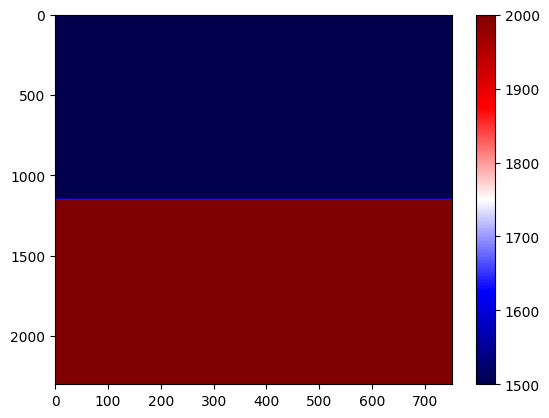

In [4]:
plt.imshow(v.cpu().numpy(), cmap='seismic', aspect='auto')
plt.colorbar()

Next we will specify where we wish to place the sources and receivers, and what the source wavelets should be. Deepwave can propagate batches of shots simultaneously. This is purely to improve computational performance - they do not interact with each other and the results should be the same as if the shots were propagated individually. Shots propagated simultaneously are assumed to have the same number of sources and receivers, so we can provide their locations in Tensors with dimensions [shot, source, space], and [shot, receiver, space], respectively, and the source amplitudes in a Tensor with dimensions [shot, source, time]. Many applications only have one source per shot, so the source dimension will be of unit length, but Deepwave provides to option to have more:

In [5]:
n_shots = 1

n_sources_per_shot = 1
d_source = 20  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 2  # 2 * 4m = 8m
# first_source = int(ny/2)
# source_depth = int(2*nx/3)

n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

n_receivers_per_shot = min(n_receivers_per_shot, int(nx/d_receiver))

freqs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

nt = 750 * 3
dt = 0.004


# source_locations
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(n_shots) * d_source +
                             first_source)

# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

Both spatial dimensions are treated equally in Deepwave. In this example we chose to orient our velocity model so that dimension 0 is horizontal and dimension 1 is vertical, and specified our source and receiver locations in a way that is consistent with that, but we could have transposed the model and used dimension 0 as depth if we wished.

That’s all the setup that we need for forward modelling, so we are now ready to call Deepwave. As we would like to ensure that the results are as accurate as possible, we will specify that we wish to use 8th order accurate spatial finite differences:

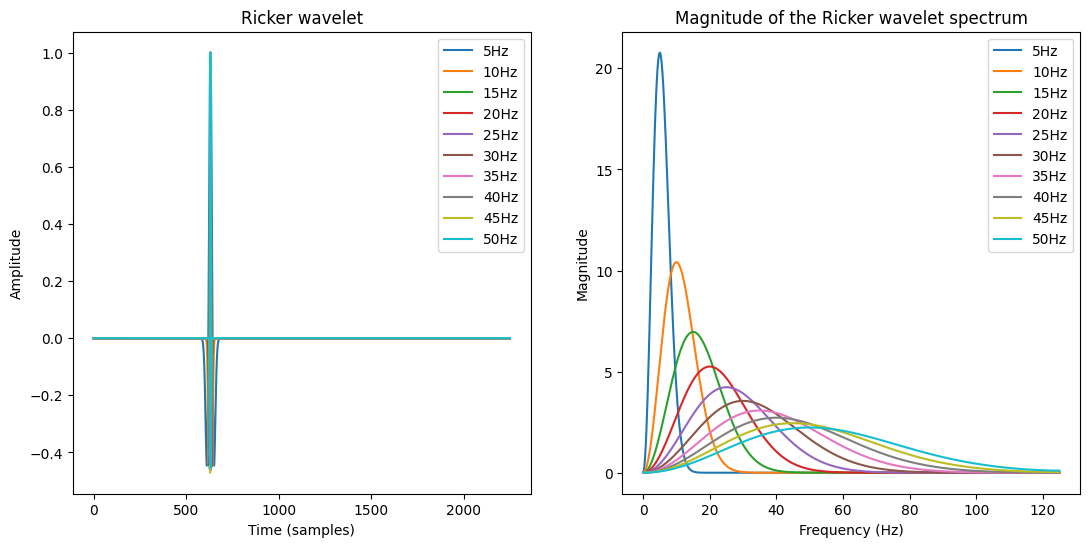

In [6]:
plt.figure(figsize=(13, 6))
peak_time = 50.5 / freqs[3]
for freq in freqs:
    # peak_time = 50.5 / freq
    ricker_wavelet = deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    # normalize the wavelet
    ricker_wavelet /= torch.max(torch.abs(ricker_wavelet))

    plt.subplot(121)
    plt.plot(ricker_wavelet, label=f"{freq}Hz")
    plt.title('Ricker wavelet')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.subplot(122)
    absolute_spectra = np.fft.rfft(ricker_wavelet)
    frequencies = np.fft.rfftfreq(len(ricker_wavelet), dt)

    # plt.plot(frequencies, np.absolute(absolute_spectra))
    # plt.plot(frequencies, np.angle(absolute_spectra), label="Phase")
    plt.plot(frequencies, np.absolute(absolute_spectra), label=f"{freq}Hz")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude of the Ricker wavelet spectrum')
    plt.legend()

In [7]:
win_len = 1
overlap = 0
samples_per_sec = 1/dt
num_frames = int(samples_per_sec * (win_len/2)) + 1
event_detection = np.empty((len(freqs), num_frames))
event_detection_qr = np.empty((len(freqs), num_frames))
event_detection_svd = np.empty((len(freqs), num_frames))

noise_detection = np.empty((len(freqs), num_frames))
noise_detection_qr = np.empty((len(freqs), num_frames))
noise_detection_svd = np.empty((len(freqs), num_frames))
for freq in freqs:
    f_ind = freqs.index(freq)
    peak_time = 20 / freq
    # source_amplitudes
    source_amplitudes = (
        deepwave.wavelets.ricker(freq, nt, dt, peak_time)
        .repeat(n_shots, n_sources_per_shot, 1)
        .to(device)
    )

    out = scalar(v, dx, dt, source_amplitudes=source_amplitudes,
                source_locations=source_locations,
                receiver_locations=receiver_locations,
                accuracy=8,
                pml_freq=freq)

    # select shots to use for coherence
    receiver_amplitudes = out[-1]
    coherence_data = receiver_amplitudes[0].cpu().numpy()
    nr, nc = coherence_data.shape
    # create noise
    noise = np.random.normal(scale=1, size=(nr,nc))
    # normalize noise
    noise = noise / np.linalg.norm(noise)
    # scale noise
    noise = noise * np.max(np.abs(coherence_data)) * 20
    # add noise to data
    coherence_data = coherence_data + noise

    # compute normalised windowed spectra
    norm_win_spectra, frequencies = f.normalised_windowed_spectra(coherence_data, win_len, overlap, sample_interval=1/samples_per_sec)
    norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(noise, win_len, overlap, sample_interval=1/samples_per_sec)

    # compute coherence matrix
    welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
    coherence = np.absolute(welch_coherence_mat)**2

    welch_coherence_mat_noise = np.matmul(norm_win_spectra_noise, np.conjugate(norm_win_spectra_noise.transpose(0,2,1)))
    coherence_noise = np.absolute(welch_coherence_mat_noise)**2

    # num_frames = coherence.shape[0]
    for d in range(num_frames):
        eigenvals = np.linalg.eigvalsh(coherence[d])
        eigenvals = np.sort(eigenvals)[::-1]
        event_detection[d] = np.max(eigenvals)/np.sum(eigenvals)

        eigenvals = np.linalg.eigvalsh(coherence_noise[d])
        eigenvals = np.sort(eigenvals)[::-1]
        noise_detection[d] = np.max(eigenvals)/np.sum(eigenvals)


    for d in range(num_frames):
        Q,R = np.linalg.qr(norm_win_spectra[d])
        
        RRH = R@(np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH),0.5)
        event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)

        Q,R = np.linalg.qr(norm_win_spectra_noise[d]) 
        RRH = R@(np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH),1)
        noise_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)

    for d in range(num_frames):
        U, S, Vh = np.linalg.svd(norm_win_spectra[d])
        svd_approx2 = S**1
        # svd_approx2 = np.sort(S)[::-1]**2
        event_detection_svd[d] = np.max(svd_approx2)/np.sum(svd_approx2)

        U, S, Vh = np.linalg.svd(norm_win_spectra_noise[d])
        svd_approx2 = S**1
        # svd_approx2 = np.sort(S)[::-1]**2
        noise_detection_svd[d] = np.max(svd_approx2)/np.sum(svd_approx2)
    

C:\Users\issah\AppData\Local\Temp\ipykernel_5128\3388326591.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)
C:\Users\issah\AppData\Local\Temp\ipykernel_5128\3388326591.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  noise_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)


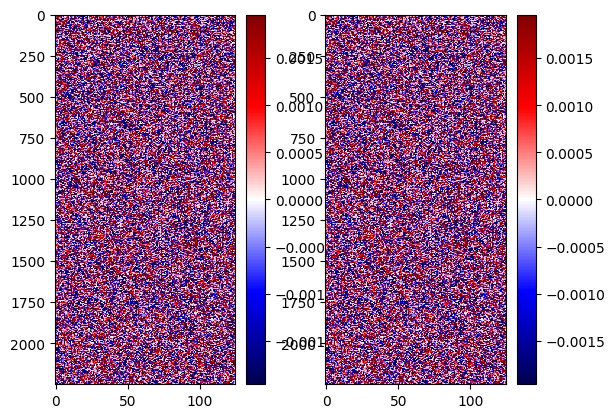

In [8]:
coherence_data = receiver_amplitudes[0].cpu().numpy()
nr, nc = coherence_data.shape
noise = np.random.normal(scale=1, size=(nr,nc))
# normalize noise
noise = noise / np.linalg.norm(noise)
noise = noise * np.max(np.abs(coherence_data)) * 40
coherence_data = coherence_data + noise
# coherence_data.shape
vmin, vmax = torch.quantile(receiver_amplitudes[0],
                            torch.tensor([0.1, 0.999]).to(device))
plt.subplot(1,2,1)
plt.imshow(coherence_data.T, aspect='auto', cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noise.T, aspect='auto', cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()

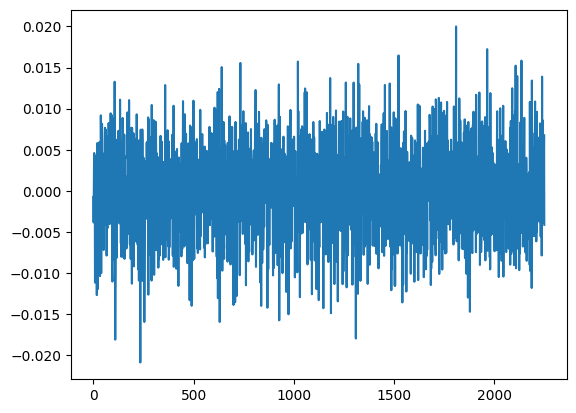

In [9]:
plt.plot(coherence_data[19])

C:\Users\issah\AppData\Local\Temp\ipykernel_5128\455643256.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fsize)
C:\Users\issah\AppData\Local\Temp\ipykernel_5128\455643256.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fsize)
C:\Users\issah\AppData\Local\Temp\ipykernel_5128\455643256.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fsize)
C:\Users\issah\AppData\Local\Temp\ipykernel_5128\455643256.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend

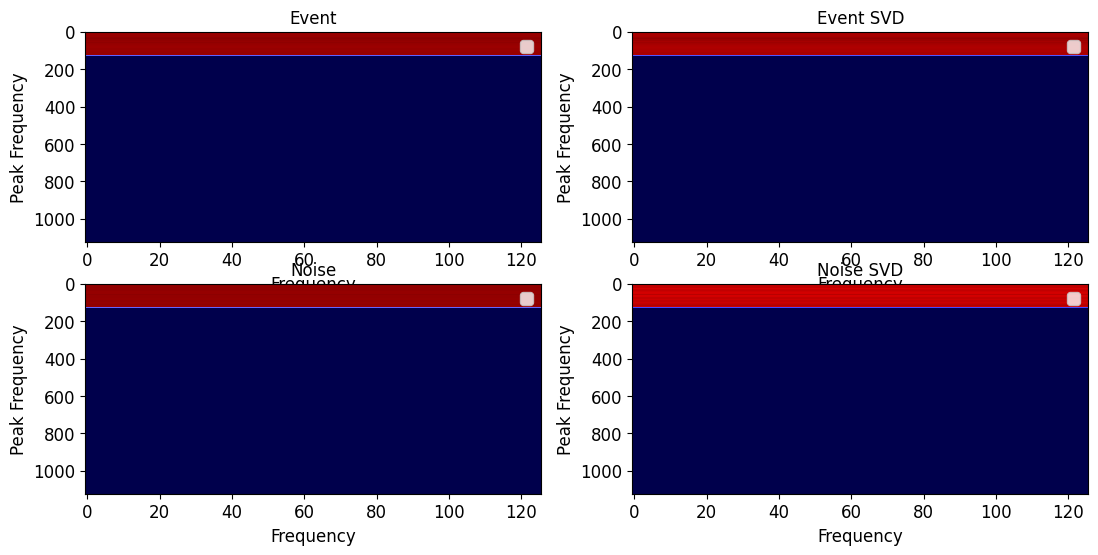

In [10]:
fsize = 12
last_freq_index = -1
f_plot = np.linspace(0, 124, num_frames)
plt.figure(figsize=(20,6))
plt.subplot(2,3,1)
plt.imshow(event_detection[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Event",fontsize=fsize)
# plt.legend(fontsize=fsize)

plt.subplot(2,3,4)
plt.imshow(noise_detection[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Noise",fontsize=fsize)
# plt.legend(fontsize=fsize)

plt.subplot(2,3,2)
plt.imshow(event_detection_qr[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
# plt.xlabel("Frequency",fontsize=fsize)
# plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Event QR",fontsize=fsize)
# plt.legend(fontsize=fsize)

plt.subplot(2,3,5)
plt.imshow(noise_detection_qr[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Noise QR",fontsize=fsize)
# plt.legend(fontsize=fsize)

plt.subplot(2,3,3)
plt.imshow(event_detection_svd[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
# plt.xlabel("Frequency",fontsize=fsize)
# plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Event SVD",fontsize=fsize)
# plt.legend(fontsize=fsize)

plt.subplot(2,3,6)
plt.imshow(noise_detection_qr[1:last_freq_index], aspect='auto', cmap='seismic')
# plt.ylabel("Detection parameter",fontsize=fsize)
# plt.ylabel("Peak Frequency",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.yticks(fontsize=fsize)
plt.title("Noise SVD",fontsize=fsize)
# plt.legend(fontsize=fsize)

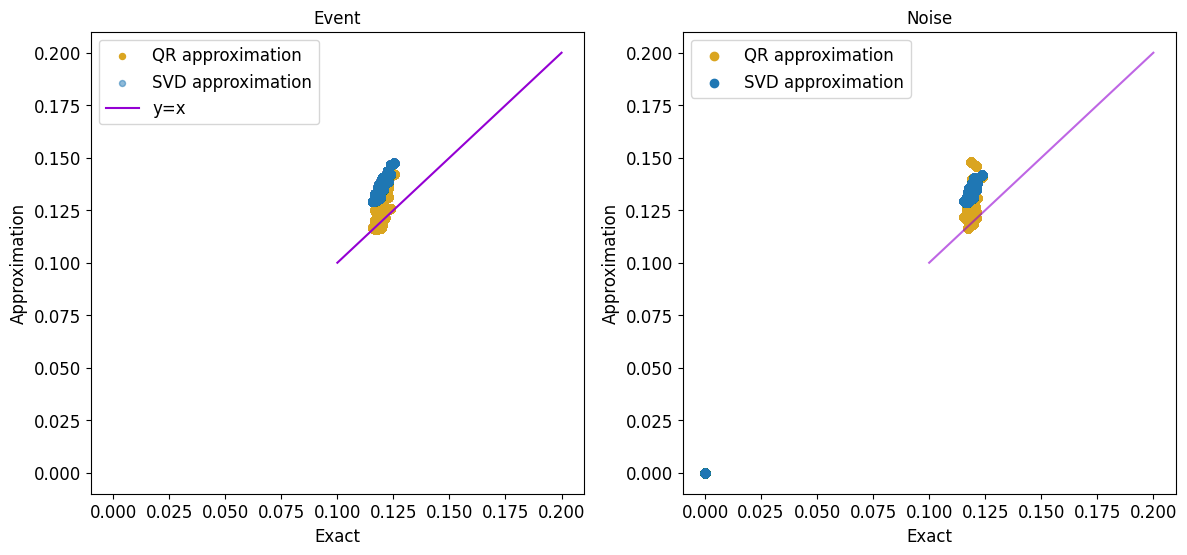

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(event_detection[1:last_freq_index], event_detection_qr[1:last_freq_index], s=event_detection[1:last_freq_index]*300, color="goldenrod", label='QR approximation')
plt.scatter(event_detection[1:last_freq_index], event_detection_svd[1:last_freq_index], s=event_detection[1:last_freq_index]*300, alpha=0.5, label='SVD approximation')
plt.plot([0.1,0.2],[0.1,0.2], color="darkviolet", label="y=x")
# xx = np.linspace(0.1,1,100)
# # yy = np.power(xx,0.5) - (1-xx)**10
# yy = np.cos(0.6*(xx-1)*np.pi)**0.8
# plt.plot(xx,yy, color="darkviolet", linestyle="--", label="y=x^0.5")

plt.ylabel("Approximation",fontsize=fsize)
plt.xlabel("Exact",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Event",fontsize=fsize)
plt.legend(fontsize=fsize)

plt.subplot(1,2,2)

plt.scatter(noise_detection[1:last_freq_index], noise_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.scatter(noise_detection[1:last_freq_index], noise_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot([0.1,0.2],[0.1,0.2], color="darkviolet", alpha=0.6)


plt.ylabel("Approximation",fontsize=fsize)
plt.xlabel("Exact",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Noise",fontsize=fsize)
plt.legend(fontsize=fsize)

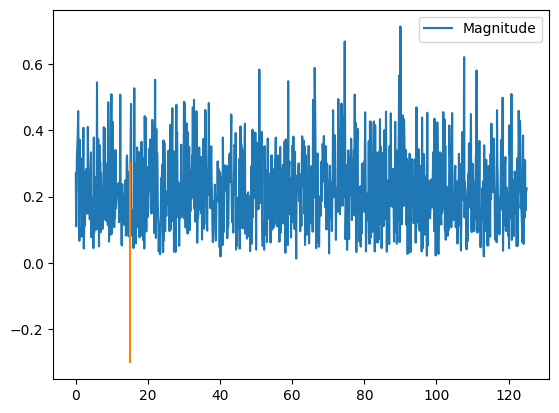

In [12]:
absolute_spectra = np.fft.rfft(coherence_data[20])
frequencies = np.fft.rfftfreq(len(coherence_data[20]), dt)

# plt.plot(frequencies, absolute_spectra.imag, label="Imaginary")
# plt.plot(frequencies, absolute_spectra.real, label="Real")
plt.plot(frequencies, np.absolute(absolute_spectra), label="Magnitude")
# plt.plot(frequencies, np.angle(absolute_spectra), label="Phase")
plt.plot([15, 15], [-0.3,0.3])
plt.legend()